refer: https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu

Reference: https://keras.io/examples/keras_recipes/creating_tfrecords/

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  84566      0 --:--:-- --:--:-- --:--:-- 84566
OK
50 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 50 not upgraded.
Need to get 10.8 MB of archives.
After this operation, 23.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.36.0_amd64.deb ...
Unpacking gcsfuse (0.36.0) ...
Setting up gcsfuse (0.36.0) ...


In [ ]:
!mkdir googleBucketFolder
!gcsfuse --implicit-dirs protonx-dataset googleBucketFolder

2021/08/19 09:59:34.346440 Using mount point: /content/googleBucketFolder
2021/08/19 09:59:34.353864 Opening GCS connection...
2021/08/19 09:59:34.765443 Mounting file system "protonx-dataset"...
2021/08/19 09:59:34.800558 File system has been successfully mounted.


In [ ]:
import math, re, os, time
import tensorflow as tf
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.6.0


TPU or GPU detection


In [ ]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.114.41.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.41.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


Write image tf records

In [ ]:
root_dir = "datasets"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = (
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "images.zip", cache_dir=os.path.abspath("."), origin=images_url, extract=True,
    )
    os.remove(image_zip)

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=annotations_url,
        extract=True,
    )
    os.remove(annotation_zip)

print("The COCO dataset has been downloaded and extracted successfully.")


252919808/252907541 [==============================] - 3s 0us/step
The COCO dataset has been downloaded and extracted successfully.


In [ ]:
import json
with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of images: {len(annotations)}")

Number of images: 36781


In [ ]:
import pprint
pprint.pprint(annotations[60])


{'area': 367.89710000000014,
 'bbox': [265.67, 222.31, 26.48, 14.71],
 'category_id': 72,
 'id': 34096,
 'image_id': 525083,
 'iscrowd': 0,
 'segmentation': [[267.51,
                   222.31,
                   292.15,
                   222.31,
                   291.05,
                   237.02,
                   265.67,
                   237.02]]}


In [ ]:
tfrecords_dir = "coco-tfrecords"
num_samples = 4096
num_tfrecods = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecods += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder

In [ ]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

Generating TF Records

In [ ]:
for tfrec_num in range(num_tfrecods):
    samples = annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]
    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = f"{images_dir}/{sample['image_id']:012d}.jpg"
            with open(image_path, "rb") as local_file: # <= change here
              raw = local_file.read()
              image = tf.image.decode_jpeg(raw)
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

Explore One Record

In [ ]:
!cp -r /content/coco-tfrecords /content/googleBucketFolder

bbox: [473.07 395.93  38.65  28.67]
area: 702.1057739257812
category_id: 18
id: 1768
image_id: 289343
path: b'datasets/val2017/000000289343.jpg'
Image shape: (640, 529, 3)


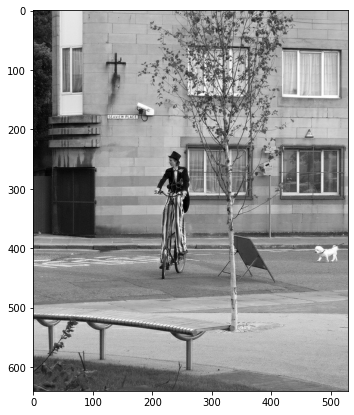

In [ ]:
gcs_tfrecords_dir = 'gs://protonx-dataset/coco-tfrecords'
raw_dataset = tf.data.TFRecordDataset(f"{gcs_tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()